#  Reinforcement learning based training of modulation scheme without a channel model

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* End-to-end-learning of modulation scheme without a channel model using policy learning (policy gradient) 

This code is based on the Fayçal Ait Aoudia, Jakob Hoydis, "End-to-End Learning of Communications Systems Without a Channel Model" (https://arxiv.org/pdf/1804.02276.pdf).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


### Define Transmitter, Channel, Recevier and helper functions

In [2]:
class Transmitter(nn.Module):
    def __init__(self):
        super(Transmitter, self).__init__()
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        # the matrix defines just a mapping between one-hot vectors and modulation symbols
        self.W = nn.Parameter(torch.empty(M,2))
        nn.init.xavier_uniform_(self.W)
    
    def normalize(self, x):
        # Normalize the power of the transmit symbols to 1
        norm_factor = torch.sqrt(torch.mean(torch.sum(torch.square(x), 1)))
        return norm_factor
    
    def forward(self, x):
        # compute output
        norm_factor = self.normalize(self.W)
        out = torch.matmul(x, self.W/norm_factor)
        return out

In [3]:
def receiver(modulation_symbols, received):
    # minimum euclidean distance receiver: returns a 1 for the modulation symbols with the minimum distance 
    rx_sym_onehot = torch.zeros(len(received), len(modulation_symbols), device=device)
    
    # Calculate the distance between the received symbol and all modulation symbols
    # Remark: looping over all received symbols is very slow -> loop over the modulation symbols
    rx_dist = torch.zeros(len(received), len(modulation_symbols), device=device)
    for i in range(len(modulation_symbols)):
        rx_dist[:,i] = torch.sqrt(torch.square(modulation_symbols[i,0]-received[:,0])+torch.square(modulation_symbols[i,1]-received[:,1]))
    
    # Return 1 for the modulation sybmol with the minimum distance
    rx_sym_onehot[range(rx_sym_onehot.shape[0]), torch.argmin(rx_dist, dim=1).long()]=1
    return rx_sym_onehot

In [4]:
def channel_model(x):
    # AWGN-channel (adds Gaussian noise with standard deviatian sigma_n)
    received = torch.add(x, sigma_n*torch.randn(len(x),2, device=device))
    return received

Helper function to compute Symbol Error Rate (SER)

In [5]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

In [6]:
# This loss function is equivalent to the SER 
def my_loss_fn(predicitions, labels):
    same = torch.zeros(len(predicitions), device=device)
    same = torch.where(torch.argmax(predicitions, 1) == torch.argmax(labels, 1), same, torch.FloatTensor([1]).to(device))
    return same

### Parameter and Training
Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [9]:
# number of symbols
M = 16

EbN0 = 7

# noise standard deviation (of the channel)
sigma_n = np.sqrt((1/2/np.log2(M)) * 10**(-EbN0/10))

# validation set. Training examples are generated on the fly
N_valid = 100000

# variance of policy vector
sigma_p = np.sqrt(0.02)

# Generate Validation Data
y_valid = np.random.randint(M,size=N_valid)
y_valid_onehot = np.eye(M)[y_valid]

# meshgrid for plotting
# assume that the worst case constellation is the one where all points lie on a straight line starting at the center
# and then are spreaded equidistantly. In this case, this is the scaling factor of the constellation points and
# we assume that there is an (M+1)th point which defines ext_max 
ext_max = 1.8
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,400), np.linspace(-ext_max,ext_max,400))
meshgrid = np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1))))

Now, carry out the training as such. First initialize the variables and then loop through the training. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data.

In [25]:
# Initilize Transmitter
model_tx = Transmitter()
model_tx.to(device)


# Adam Optimizers for TX
optimizer_tx = optim.Adam(model_tx.parameters(), lr=5e-4)  

# Training parameters
num_epochs = 100
batches_per_epoch = 50

# Vary batch size during training
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=np.int16)

validation_SERs = np.zeros(num_epochs)
validation_received = []
decision_region_evolution = []
constellations = []

pg_loss_list = []

print('Start Training')
for epoch in range(num_epochs):
       
    batch_labels = torch.empty(batch_size_per_epoch[epoch], device=device)
           
    # Optimize Transmitter  
    for step in range(batches_per_epoch):
        # Generate training data: In most cases, you have a dataset and do not generate a training dataset during training loop
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(M)
        batch_labels_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), M, device=device)
        batch_labels_onehot[range(batch_labels_onehot.shape[0]), batch_labels.long()]=1

        # Propagate (training) data through the net
        tx_output = model_tx(batch_labels_onehot)
        tx_output_clone = tx_output.clone().detach()
        
        # apply policy, which is Gaussian noise
        noise = (sigma_p / np.sqrt(2)) * torch.randn_like(tx_output).to(device)               
        encoded = np.sqrt(1-(sigma_p**2))*tx_output + noise      
            
        # channel model
        encoded_clone = encoded.clone().detach()
        received = channel_model(encoded_clone)
        
        const_diagram = (1/model_tx.normalize(model_tx.W.detach()))*model_tx.W
        
        # Estimate transmit symbols
        logits = receiver((1/model_tx.normalize(model_tx.W.detach()))*model_tx.W.detach(), received)
        
        # compute per example losses ... detach from graph so that the gradient is not computed        
        per_example_losses = my_loss_fn(logits, batch_labels_onehot).detach()
        
        # policy gradient loss
        pg_loss = (1/batch_size_per_epoch[epoch])*torch.sum(
            per_example_losses * torch.log(
                (1/(np.pi * sigma_p**2))*torch.exp(-1/(sigma_p**2)*torch.sum(torch.square(
                    encoded_clone-np.sqrt(1-(sigma_p**2))*tx_output), 1)
                )
            )
        )    
            
        # compute gradients
        pg_loss.backward()
        
        # Adapt weights
        optimizer_tx.step()
        
        # reset gradients
        optimizer_tx.zero_grad()
        
    
    # print(torch.mean(per_example_losses))
        
    # compute validation SER
    with torch.no_grad():
        encoded_valid = model_tx(torch.Tensor(y_valid_onehot).to(device))
        received_valid = channel_model(encoded_valid)
        out_valid = receiver((1/model_tx.normalize(model_tx.W.detach()))*model_tx.W.detach(), received_valid)
        validation_SERs[epoch] = SER(out_valid.detach().cpu().numpy().squeeze(), y_valid)      
        print('Validation SER after epoch %d: %f (pg_loss %1.8f)' % (epoch, validation_SERs[epoch], pg_loss.detach().cpu().numpy()))               

        # calculate and store received validation data
        encoded = model_tx(torch.Tensor(y_valid_onehot).to(device))
        received = channel_model(encoded)
        validation_received.append(received.detach().cpu().numpy())

        # calculate and store constellation
        encoded = model_tx(torch.eye(M).to(device))
        constellations.append(encoded.detach().cpu().numpy())

        # store decision region for generating the animation
        # mesh_prediction = softmax(model_rx(torch.Tensor(meshgrid).to(device)))
        mesh_prediction = receiver((1/model_tx.normalize(model_tx.W.detach()))*model_tx.W.detach(), torch.Tensor(meshgrid).to(device))
        decision_region_evolution.append(mesh_prediction.detach().cpu().numpy())

print('Training finished! The constellation points are:')
print(model_tx.W)

Start Training
Validation SER after epoch 0: 0.169240 (pg_loss 0.26196429)
Validation SER after epoch 1: 0.146290 (pg_loss 0.27764556)
Validation SER after epoch 2: 0.128680 (pg_loss 0.24826218)
Validation SER after epoch 3: 0.116020 (pg_loss 0.29214489)
Validation SER after epoch 4: 0.103110 (pg_loss 0.18954459)
Validation SER after epoch 5: 0.093980 (pg_loss 0.18737641)
Validation SER after epoch 6: 0.087530 (pg_loss 0.25935403)
Validation SER after epoch 7: 0.081540 (pg_loss 0.18902481)
Validation SER after epoch 8: 0.076730 (pg_loss 0.23757990)
Validation SER after epoch 9: 0.075900 (pg_loss 0.22596151)
Validation SER after epoch 10: 0.072240 (pg_loss 0.16311055)
Validation SER after epoch 11: 0.071870 (pg_loss 0.18262082)
Validation SER after epoch 12: 0.070110 (pg_loss 0.17208798)
Validation SER after epoch 13: 0.066770 (pg_loss 0.16894382)
Validation SER after epoch 14: 0.065810 (pg_loss 0.16764960)
Validation SER after epoch 15: 0.065930 (pg_loss 0.19101170)
Validation SER afte

### Evaluation
Plot decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing SERs and plotting, there is no feedback towards the training!

In [18]:
# find minimum SER from validation set
min_SER_iter = np.argmin(validation_SERs)
print('Minimum SER obtained: %1.5f' % validation_SERs[min_SER_iter])

Minimum SER obtained: 0.05430


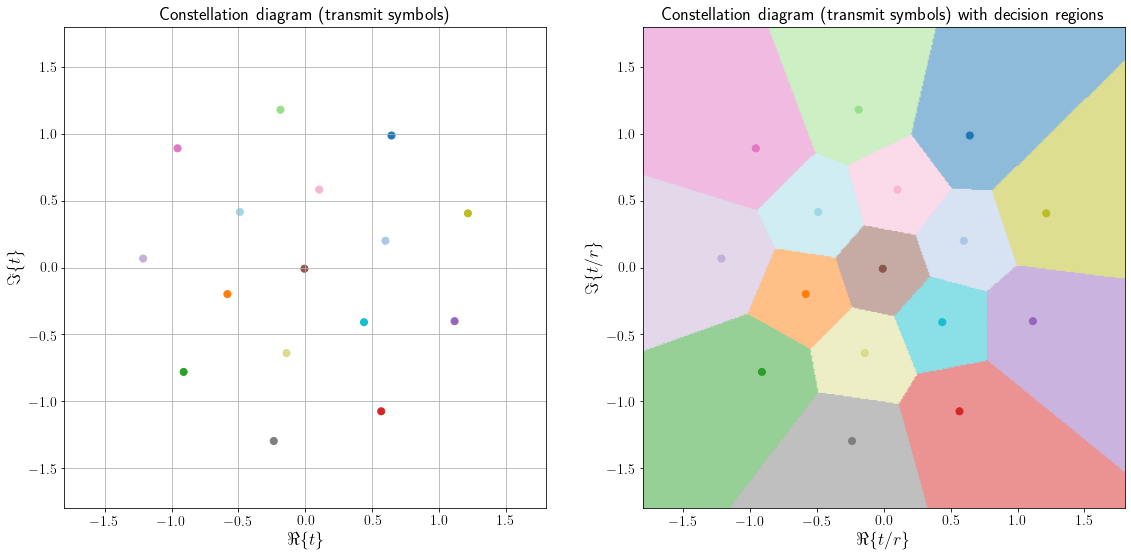

In [21]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

%matplotlib inline
plt.figure(figsize=(19,9.5))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    
plt.subplot(121)
plt.scatter(constellations[min_SER_iter][:,0], constellations[min_SER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlabel(r'$\Re\{t\}$',fontsize=18)
plt.ylabel(r'$\Im\{t\}$',fontsize=18)
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.grid(which='both')
plt.title('Constellation diagram (transmit symbols)',fontsize=18)

plt.subplot(122)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(constellations[min_SER_iter][:,0], constellations[min_SER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.xlabel(r'$\Re\{t/r\}$',fontsize=18)
plt.ylabel(r'$\Im\{t/r\}$',fontsize=18)
plt.title('Constellation diagram (transmit symbols) with decision regions',fontsize=18)

plt.savefig('PGAE_AWGN_ML_M%d_EbN0%1.2f_const.pdf' % (M,EbN0),bbox_inches='tight')

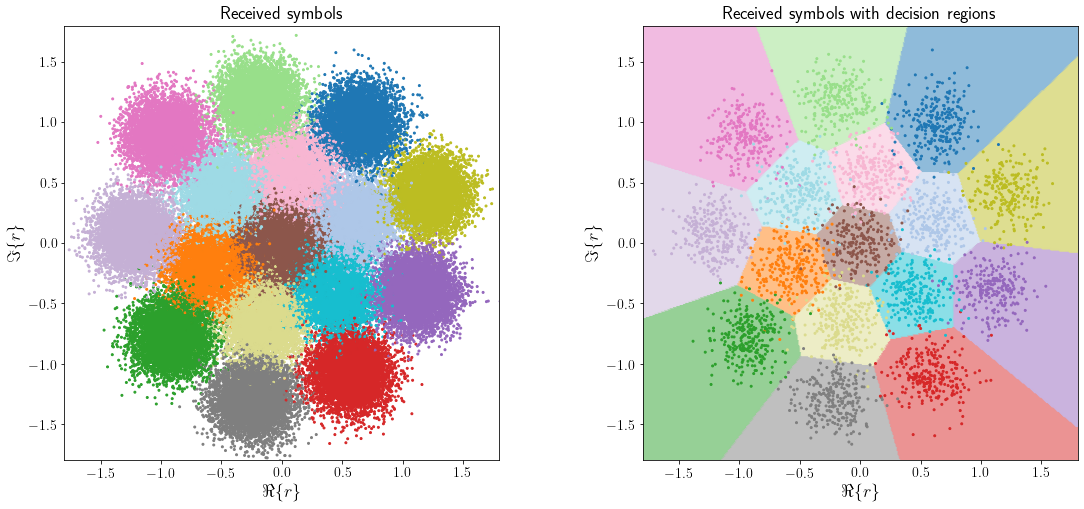

In [22]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

%matplotlib inline
plt.figure(figsize=(19,8))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

plt.subplot(121)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(validation_received[min_SER_iter][:,0], validation_received[min_SER_iter][:,1], c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=18)
plt.ylabel(r'$\Im\{r\}$',fontsize=18)
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.title('Received symbols',fontsize=18)

plt.subplot(122)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(validation_received[min_SER_iter][0:4000,0], validation_received[min_SER_iter][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
plt.axis('scaled')
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.xlabel(r'$\Re\{r\}$',fontsize=18)
plt.ylabel(r'$\Im\{r\}$',fontsize=18)
plt.title('Received symbols with decision regions',fontsize=18)

plt.savefig('PGAE_AWGN_ML_M%d_EbN0%1.2f_noisy.pdf' % (M,EbN0),bbox_inches='tight')

<IPython.core.display.Javascript object>


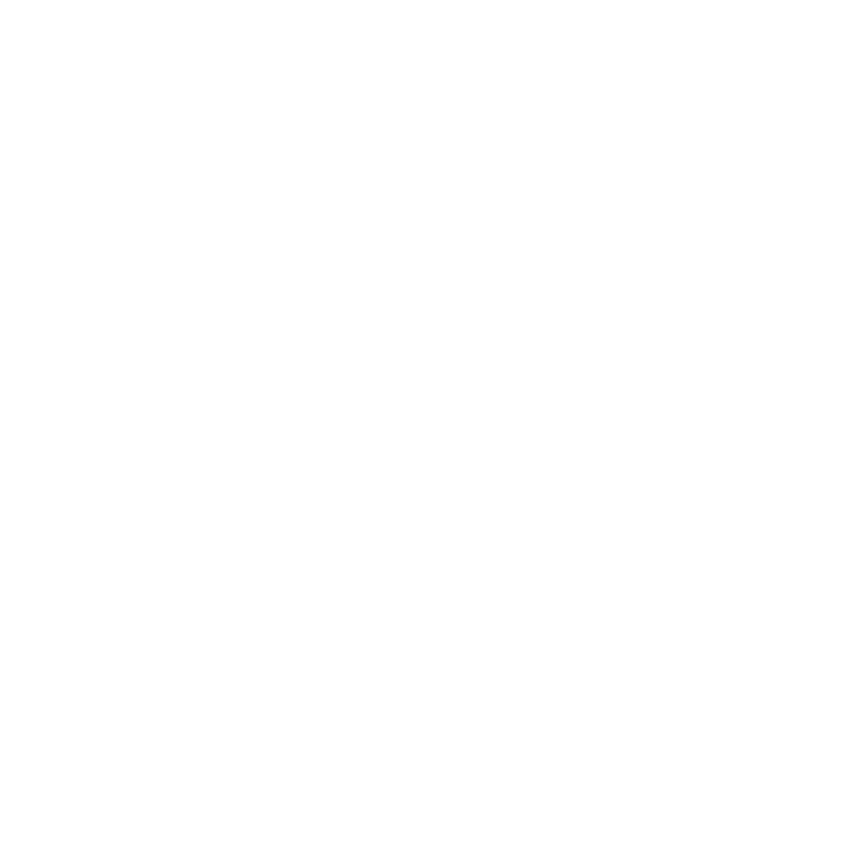

<IPython.core.display.Javascript object>


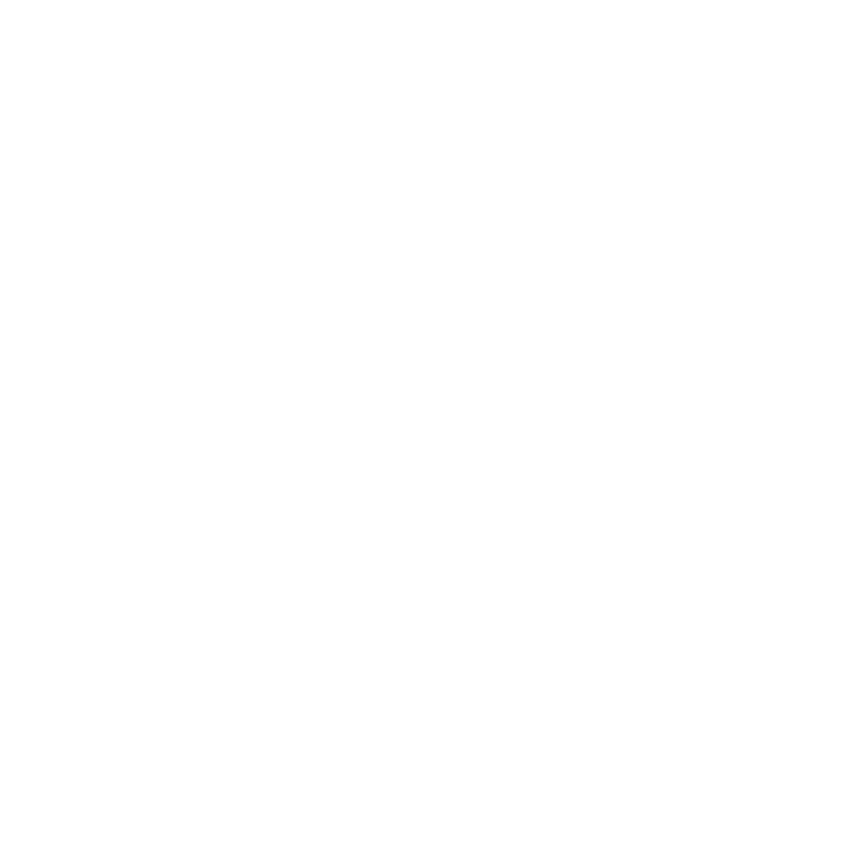

Traceback (most recent call last):
  File "/home/simulation/MLenv/lib64/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/simulation/MLenv/lib64/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [27]:
%matplotlib notebook
%matplotlib notebook

cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.axis('scaled')

written = True
def animate(i):
    ax.clear()
    decision_scatter = np.argmax(decision_region_evolution[i], 1)
    
    ax.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4, marker='s')
    ax.scatter(constellations[i][:,0], constellations[i][:,1], c=range(M), cmap='tab20',s=75)
    ax.scatter(validation_received[i][0:4000,0], validation_received[i][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
    ax.set_xlim(( -ext_max, ext_max))
    ax.set_ylim(( -ext_max, ext_max))

    ax.set_xlabel(r'$\Re\{r\}$',fontsize=18)
    ax.set_ylabel(r'$\Im\{r\}$',fontsize=18)

anim = animation.FuncAnimation(fig, animate, frames=num_epochs-1, interval=200, blit=False)
fig.show()
anim.save('PGAE_AWGN_ML_M%d_EbN0%1.2f_anim.gif' % (M,EbN0), writer=PillowWriter(fps=5))